# Прооект: Определение стоимости автомобилей

## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 
Необходимо построить модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

## Техническое задание

1. **Предобработка данных**
    - Правильно выгрузить данные, исправить недочеты имеющиеся при выгрузке
    - Исследовать пропуски
    - Исследовать аномальные значения
    - Ислледовать распределения признаков
    - Исследовать признаки на информативность
2. **Исследовательский анализ**
    - Рассмотреть все признаки в разрезе целевого признака
3. **Корреляционный анализ**
    - Исследовать данные на мультиколлениарность
4. **Подготовака данных**
    - Подготовить данные для их работы с моделями
5. **Обучение моделей**
    - Обучить модель из библиотеки LightGBM
    - Обучить как минимум одну модель не использующую бустинг
    - Подобрлать гиперпараметры для моделей
    - Проанализировать время обучения, время предсказания и качество моделей
    - Опираясь на критерии заказчика, выберать лучшую модель, проверить её качество на тестовой выборке (RMSE <= 2500)
    - Провести анализ моделей
    - Интерпритировать лучшую модель 
6. **Написать общий вывод по проделанной работе**

## Все необходимые загрузки и импорты

In [1]:
!pip install shap -q
!pip install optuna


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import warnings
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
import phik
import re

from phik.report import plot_correlation_matrix
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, KFold
from lightgbm import LGBMRegressor
from time import time

## Все функции используемые в проекте

In [3]:
def camel_to_snake(names: list) -> list:
    
    '''
    Переводит значения списка записанные в CamelCase в snake_case
    '''
    
    snake_name = []
    for name in names:
        snake_name.append(re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower())
    return snake_name

In [4]:
def distributions_plot(df: pd.DataFrame,
                       col: str,
                       bins=30,
                       xlim=None,
                       ylim=None,
                       figsize=(15, 10),
                       title=None,
                       xlabel=None,
                       ylabel='Количество значений') -> None:
   
    '''
    Функция быстро строит графики распределений числовых значений. Имеет гибкую настройку
    отображения графиков.
    ''' 

    fig, ax = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)}, figsize=figsize)

    if col in df.columns:
        sns.boxplot(x=df[col], 
                    ax=ax[0],
                    color='#8c8c8c')
        sns.histplot(df[col], 
                     ax=ax[1],
                     bins=bins,
                     color='#4f4d49',
                     edgecolor='black',
                     kde=True)
    if xlabel is None: 
        xlabel = col
        ax[0].set(xlabel='')
        ax[1].set(xlabel=xlabel, ylabel=ylabel, xlim=xlim, ylim=ylim)
        ax[1].grid(visible=True)
        
        if title == None:
            plt.suptitle(f'Рампределение значений {col}', y=0.92, fontsize=14, fontweight='bold')
        else:    
            plt.suptitle(title, y=0.92, fontsize=14, fontweight='bold')
    else:
        print('Столбец', col, 'отсутсвует в датафрейме')

In [5]:
def column_value_counts(df: pd.DataFrame,
                        column: str,
                        n_values=20,
                        fillna='None',
                        title=None,
                        xlabel='Количиство значений',
                        ylabel=None
                       ) -> None:
    
    ''' 
    Функция принимает на вход датафрейм, столбец в которм будут считаться различные 
    значения, аргумент определяющий сколько различных значений мы хотим вывести и
    аргумент который определяет на что будут заменены пропуски
    '''
    
    val_counts = df[column].fillna(fillna).value_counts()
    bar_values = val_counts.values[:n_values]
    bar_labels = val_counts.index[:n_values]
    plt.figure(figsize=(15, 10))
    ax = sns.barplot(x=bar_values, y=bar_labels)
    plt.title(title,
              fontsize=20,
              fontweight='bold'
             )    
    plt.xlabel(xlabel)
    if ylabel == None:
        plt.ylabel(column)
    else:
        plt.ylabel(ylabel)
    plt.show()
    

In [6]:
def countplot_creator(df: pd.DataFrame,
                      parametr_x,
                      parametr_y=None,
                      title=None,
                      xlabel=None,
                      ylabel='Количество значений') -> None:
    
    '''
    Функция принимает на вход датафрейм и параметры по которым будет строиться график. Так же на
    вход принимается значения которые будут подставлены в заголовок всего графика и его осей.
    
    Функция ничего не возвращает.
    '''
    
    sns.set()
    plt.figure(figsize=(15, 8))
    sns.countplot(data=df, x=parametr_x, hue=parametr_y)
    plt.title(title,
              fontsize=20,
              fontweight='bold'
             )
    if xlabel == None:
        plt.xlabel(parametr_x)
    else:
        plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [7]:
def pass_value_barh(df: pd.DataFrame) -> None:
    
    '''
    Функция принимает на вход датафрейм и строит график распределения пропущенных
    значений по каждому его столбцу
    '''
    
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = False)
            .plot(kind = 'bar', figsize = (19,6), fontsize = 16, legend=False, rot=0)
            .set_title('Доля пропущеных значений по каждому столбцу' + "\n",
                       fontsize = 20,
                       fontweight='bold'
                       )    
        );
        plt.ylabel('Процент пропусков от общего объема данных', fontsize=14)
        plt.xlabel('Названия столбцов', fontsize=14)
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции')

In [8]:
def fillna_pro(df: pd.DataFrame, target_col: str, group_col: str) -> None:
    
    '''
    Функция заменяет пропуски в столбце по аналогичным данным из других строк.
    На вход принимает датафрейм, столбец в котором будем заменять пропуски и 
    столбец по которому будем делать группировку и искать аналогичные значения.
    '''
    
    df.loc[df[target_col].isna(), target_col] = (
        df.loc[df[target_col].isna(), group_col].map(
            df.groupby(group_col)[target_col].agg(lambda x: pd.Series.mode(x)[0]))
    )

In [9]:
def scatterplot_creator(df: pd.DataFrame,
                        parametr_x: str,
                        parametr_y: str,
                        title='Распределение значений',
                        xlabel=None,
                        ylabel=None,
                        hue=None, 
                       ) -> None:
    
    '''
    Функция принимает на фход датафрейм, параметры по которым будет строиться график и 
    именя для оглавления всего графиков и имен осей. По заданным параметрам функция 
    нарисует диаграмму рассеяния и отобразит коэффициент корреляции.
    
    Функция ничего не возвращает.
    '''
    
    sns.set()
    plt.figure(figsize=(6,6)),
    sns.scatterplot(
        data=df,
        x=parametr_x,
        y=parametr_y,
        hue=hue
    )
    plt.title(title,
              fontsize=20,
              fontweight='bold'
             )
    
    if xlabel == None:
        xlabel = parametr_x
        
    plt.xlabel(xlabel)
    
    if ylabel == None:
        ylabel = parametr_y
    
    plt.ylabel(ylabel)
    plt.show()
    display(df[[parametr_y, parametr_x]].corr())

In [10]:
def residuals(y_true: any , y_pred: any, model_name=None) -> None:
    
    '''
    Функция принимает на вход сериес/список или другую списко-подобную сруктуру в кажестве
    истинного значения целевой переменной, такой же тип данных принимается в качестве
    предсказанных значений и имя модели для подписи графика.
    '''
    
    plt.figure(figsize=(10, 6))
    sns.histplot(y_true - y_pred)
    plt.title(f'Распределение остатков модели {model_name}',
              fontsize=20,
              fontweight='bold')
    plt.xlabel('Остаток')
    plt.show()
    plt.figure(figsize=(10, 6))
    plt.title(f'Дисперсия остатков модели {model_name}',
              fontsize=20,
              fontweight='bold')
    plt.xlabel('Целевой признак')
    plt.ylabel('Остаток')
    sns.scatterplot(x=y_true, y=y_pred)
    plt.show()

## Загрузка и знакомство с данными

In [11]:
try:
    df = pd.read_csv('datasets/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


На первый взгляд с данными все нормально, но в некоторых столбцах есть пропуски. Только для личного удобства считаю нужным привести название столбцов в snake_case.

In [12]:
df.columns = camel_to_snake(df.columns)
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

## Предобработка данных

Посмотрим на размер датафрейма. Проверим правильные ли типы данных в столбцах. Изучим аномальные значения и пропуски.

In [13]:
display(df.info())
display(df.describe())
print(f'Число полных дубликатов равно: {df.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

None

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Число полных дубликатов равно: 4


В датафрейме много аномальных значений. 
- Машины со стоимостью 0
- Машины выпущенные в 1000 и 9999 годах
- Месяц регистрации имеет значения от 0 до 12 - справедливо предположить, что нулевой месяц лишний
- Машины с мощьностью 0 и 20000 л.с.
- Столбец с числом картинок полностью заполнен нулями можно его удалить


В датафрейме много пропусков, чаще всего пропускает значение была ли машина в ремонте или нет. Скорее всего владельцы автомобилей машина которых не была на ремонте просто пропускают этот пункт, но постараемся это проверить.


Тип некоторых столбцов можно поменять с object на category, а после удаления аномальных, можно будет настроить разрядность целочисленных значений.

Так же столбцы date_crawled, date_created, last_seen - это информация о пользователях/продавцах, скорее такие параметры будут только мешать работе модели, поэтому предлагаю удалить их. Перед этим нужно посмотреть последнюю дату скачивания анкеты из базы, позднее чем это число автомобиль выпустить не могли.

Сохраним размер датафрейса до всех преобразований.

In [14]:
print(f'Краяйняя дата выгрузки анкет из базы: {df["date_crawled"].max()}')

Краяйняя дата выгрузки анкет из базы: 2016-04-07 14:36:58


In [15]:
df_shape_before_treatments = df.shape[0]
df_shape_before_treatments

354369

In [16]:
df.drop(['date_crawled', 'date_created', 'last_seen', 'number_of_pictures'], axis=1, inplace=True)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437


Проверим датафрейм на наличие полных дубликатов.

In [17]:
df.duplicated().sum()

21333

Дубликатов стало гораздо больше. Это можно объяснить различием в датах выгрузки из БД и тем что пользователи могли выкладывать одну и ту же анкету в разное время, т.е. по нескольку раз. Получить точно такую же анекету, с полностью одинаковыми характеристиками автомобиля (пробегом уж точно) получить практически невозможно. Поэтому удаляем их.

In [18]:
df.drop_duplicates(inplace=True)
if df.duplicated().sum() == 0:
    print('Все полные дубликаты удаены')
else:
    print('Что-то пошло не так')

Все полные дубликаты удаены


### Аномальные значения
#### price
Сначала посмотри на распределение

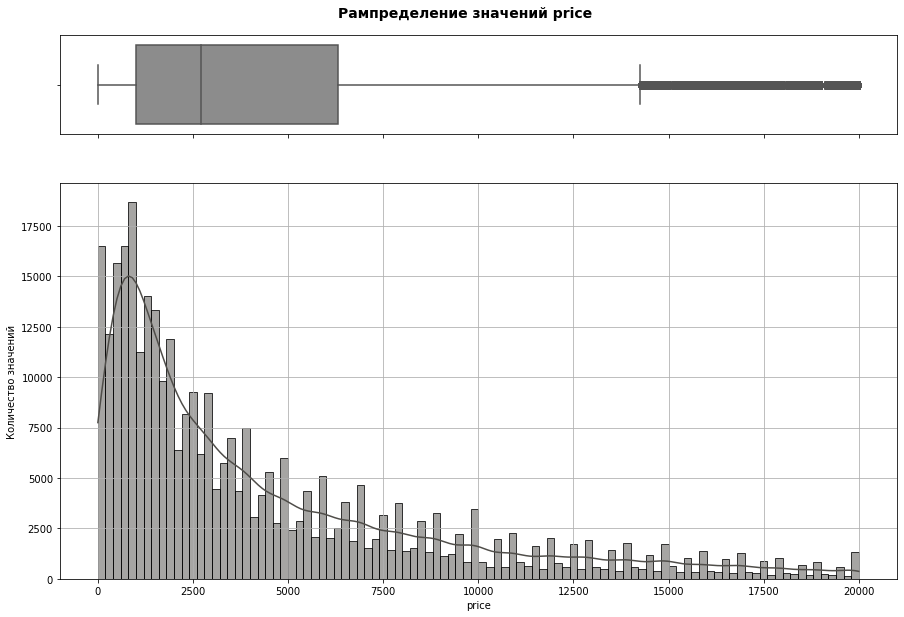

In [19]:
distributions_plot(df, 'price', bins=100)

У распределение большой хвост, но сомневаться заставляют тольуо значения находящиеся около нуля. Рассмотрим их внимательнее.

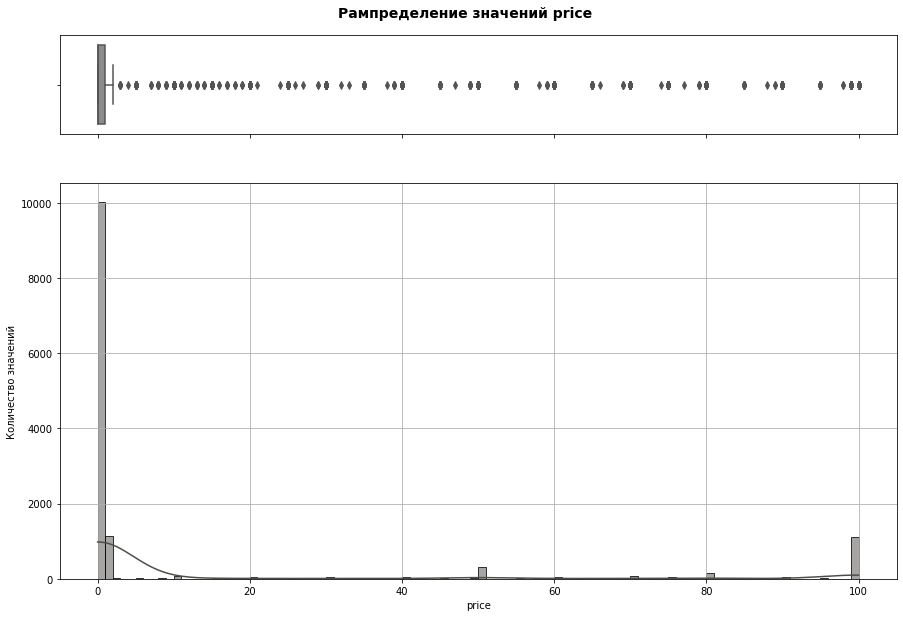

In [20]:
distributions_plot(df.query('price >= 0 and price <= 100'), 'price', bins=100)

In [21]:
df.query('price >= 0 and price <= 100').describe()

,price,registration_year,power,kilometer,registration_month,postal_code
count,13466.000000,13466.000000,13466.000000,13466.000000,13466.000000,13466.000000
mean,12.681271,2009.826155,74.255384,120935.318580,3.532749,46232.875167
std,30.467010,285.288720,222.415303,51487.667678,3.996899,26953.428621
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,1069.000000
25%,0.000000,1996.000000,0.000000,125000.000000,0.000000,25815.000000
50%,0.000000,2000.000000,60.000000,150000.000000,2.000000,44534.000000
75%,1.000000,2005.000000,115.000000,150000.000000,7.000000,66333.000000
max,100.000000,9999.000000,15016.000000,150000.000000,12.000000,99998.000000


Интересная особенность, что пользооывтели с сумашедшими характеристиками автомобилей из будущего, продают их очень дешево. Предлагаю удалить все строки в которых цена ниже или равно 100 евро.

In [22]:
df = df[df['price'] > 100]
df['price'].min()

101

Посмотрим на распределение без аномальных значений

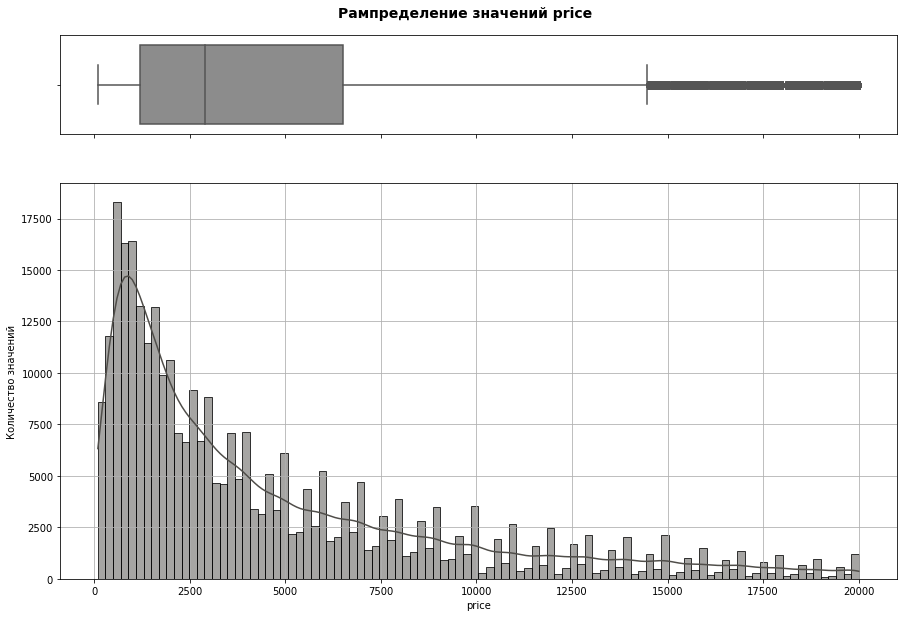

In [23]:
distributions_plot(df, 'price', bins=100)

Теперь распределение выглядит реалистично. Дорогие машины и вправду существуют и их стоит учитывать, а машины дешевле 100-а евро только испортили бы работу модели.

#### registration_year

Сначала посмотрим на распределене

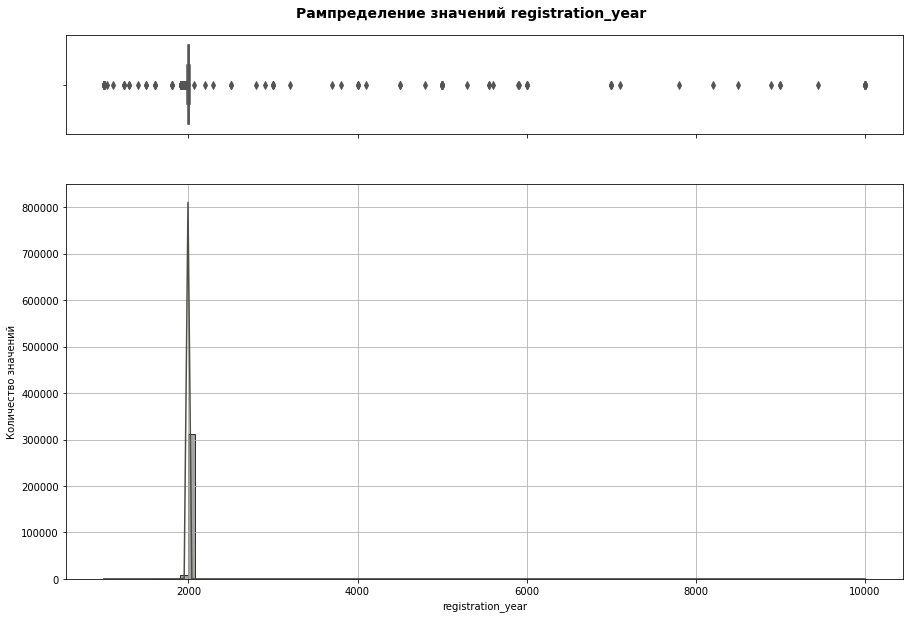

In [24]:
distributions_plot(df, 'registration_year', bins=100)

Из-за большого разброса и огромных выбосов ничего не видно. Рассмотрим машины выпузенные в промежутке от 1950 до 2016 года.

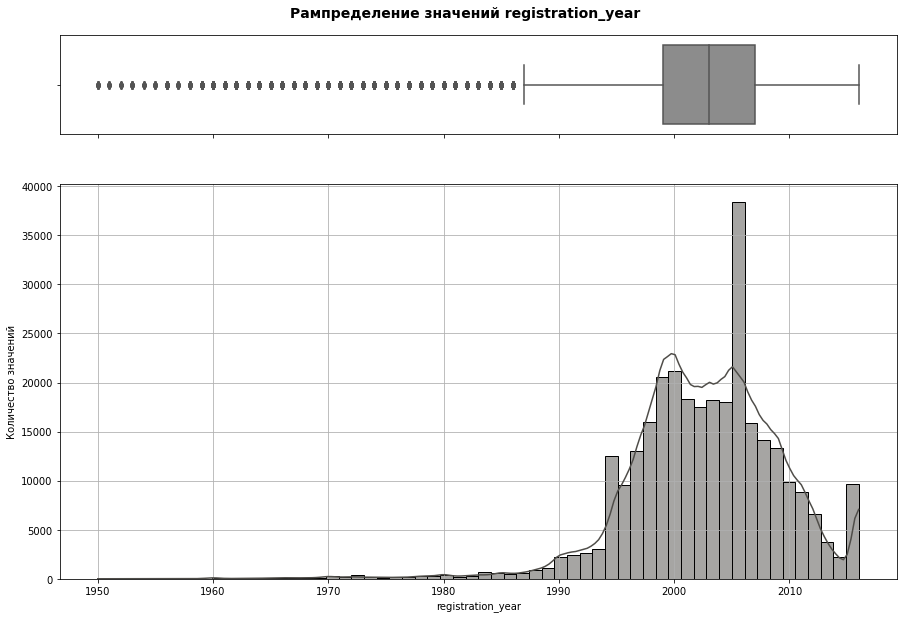

In [25]:
distributions_plot(df.query('registration_year >= 1950 and registration_year <= 2016'),
                   'registration_year', 
                   bins=60                  
                  )

Хвост слева все еще большой. Логично предположить, что автомобили вышедшие раньше 1970-ого года скорее всего в плачевном состоянии. тем более, на графике становится видно какие-либо автомобили начиная только с 1970-ого года. Поэтому дабы не вводить модель в заблуждение предлагаю удалить информацию об автомобилях вышедших до 1970, благо их не так много.

In [26]:
print(f'Количиство автомобилей вышедших рашьше 1970-ого года: {df[df["registration_year"] < 1970]["price"].count()}')

Количиство автомобилей вышедших рашьше 1970-ого года: 1088


In [27]:
df = df[df['registration_year'] >= 1970]
df = df[df['registration_year'] <= 2016]
print(f'Саммый ранний год выпуска: {df["registration_year"].min()}')
print(f'Саммый поздний год выпуска: {df["registration_year"].max()}')

Саммый ранний год выпуска: 1970
Саммый поздний год выпуска: 2016


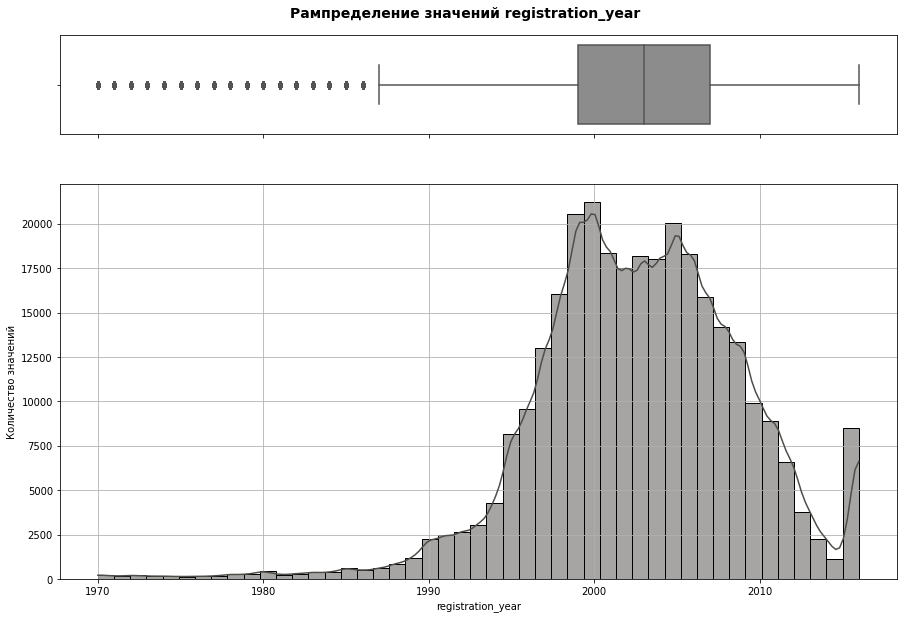

In [28]:
distributions_plot(df, 'registration_year', bins=47)

Теперь распределение выглядит правдеподобно. Есть не большой хвост слеыа, но я не думаю, что он будет сильно мешать.

#### registrartion_month
Рассмотрим в какой месяц чаще всего встречается

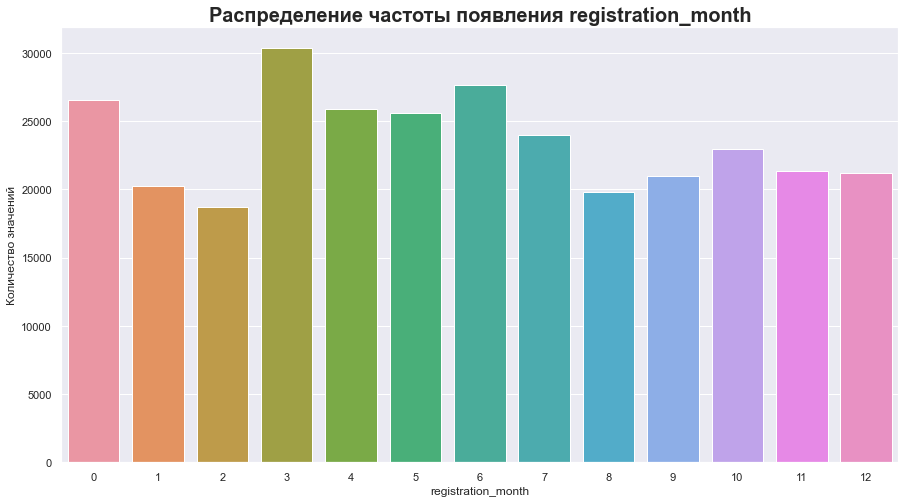

In [29]:
countplot_creator(df,
                  'registration_month',
                  title='Распределение частоты появления registration_month')

Есть подозрение, что цена очень слабо зависит от того в какой месяц автомобиль был выпущен(зарегистрирован), обычно все опираются на год выпуска. Проверим коэффициент корреляции.

In [30]:
df[['registration_month', 'price']].corr()

,registration_month,price
registration_month,1.000000,0.087819
price,0.087819,1.000000


Корреляция почти нулевая, этот столбец не нужен для обучения модели, потому что целевой признак от него никак не зависит. Можно просто удалить его.

In [31]:
df.drop('registration_month', axis=1, inplace=True)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,postal_code
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,70435
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,60437


#### power
Рассмотрим распределения значений

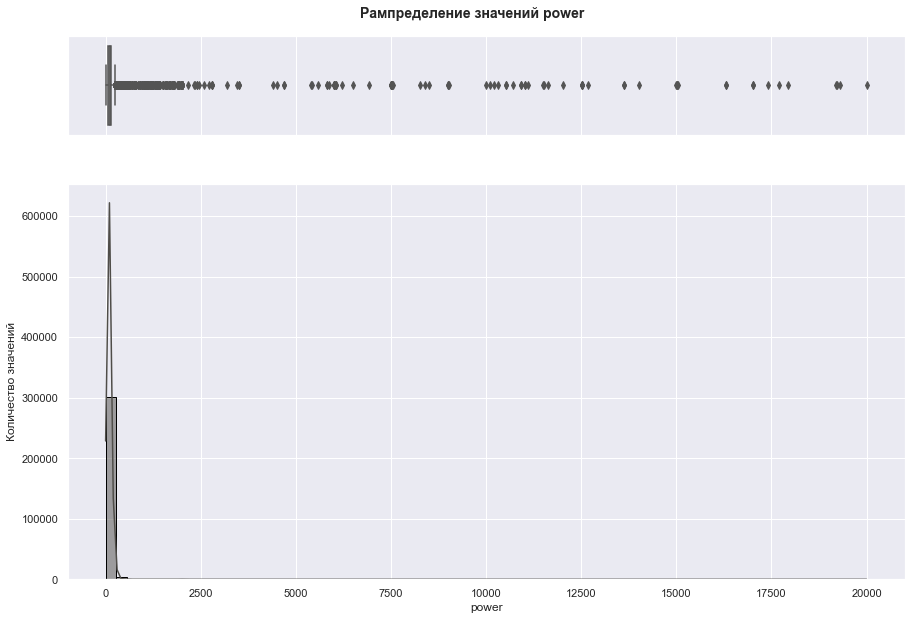

In [32]:
distributions_plot(df, 'power', bins=70)

Что и следовало ожидать слишком большой разброс, и основных данных не видно. Посмотрев информацию в интренете я выяснил, что есть машины с мощьностью от 15 л.с. верхний предел мощьности чаще всего не привышает 800 л.с.

In [33]:
print(f'Количество машин с мощьностью менее 15 л.с. : {df[df["power"] < 15]["price"].count()}')
print(f'Количество машин с мощьностью более 1000 л.с. : {df[df["power"] > 800]["price"].count()}')

Количество машин с мощьностью менее 15 л.с. : 29898
Количество машин с мощьностью более 1000 л.с. : 275


Мы теряем достаточно большой кусок данных, но заменить значение мощьности мы не сможем, поэтому эти данные придется удалить.

In [34]:
df = df.query('power >= 15 and power <= 800')
display(df['power'].min())

15

Рассмотрим распределение без выбросов

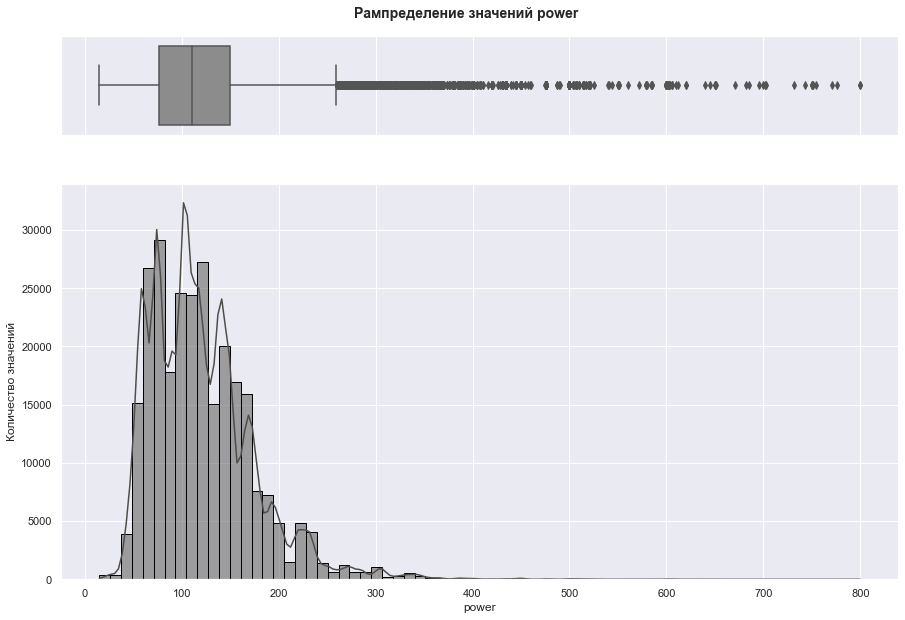

In [35]:
distributions_plot(df, 'power', bins=70)

Конечно хвост присутствует, но я думаю не конкретно исключать эти автомобили, потому что они действительно есть в свободном доступе, плюс в нашей выборке их не мало.

In [36]:
display(df.info())
display(df.describe())
print(f'Число полных дубликатов равно: {df.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275218 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              275218 non-null  int64 
 1   vehicle_type       264814 non-null  object
 2   registration_year  275218 non-null  int64 
 3   gearbox            270153 non-null  object
 4   power              275218 non-null  int64 
 5   model              264940 non-null  object
 6   kilometer          275218 non-null  int64 
 7   fuel_type          260410 non-null  object
 8   brand              275218 non-null  object
 9   repaired           234771 non-null  object
 10  postal_code        275218 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 25.2+ MB


None

,price,registration_year,power,kilometer,postal_code
count,275218.000000,275218.000000,275218.000000,275218.000000,275218.000000
mean,4834.998921,2002.894396,120.735653,128577.454963,51450.646927
std,4595.969859,6.241763,53.962024,36515.797868,25770.338702
min,101.000000,1970.000000,15.000000,5000.000000,1067.000000
25%,1350.000000,1999.000000,77.000000,125000.000000,31089.000000
50%,3150.000000,2003.000000,111.000000,150000.000000,50389.000000
75%,6950.000000,2007.000000,150.000000,150000.000000,72275.000000
max,20000.000000,2016.000000,800.000000,150000.000000,99998.000000


Число полных дубликатов равно: 1715


В данных опять появились дубликаты, скорее всего они появились, после удаление месяца выхода автомобиля. Ничего страшного мы их удаляем, чтобы не мешать работе будующих моделей.

In [37]:
df.drop_duplicates(inplace=True)
if df.duplicated().sum() == 0:
    print('Все полные дубликаты удаены')
else:
    print('Что-то пошло не так')

Все полные дубликаты удаены


Посмотрим какой процент данных мы потеряли при отборе аномальных значений.

In [38]:
print(f'Процент потерянных даннх: {(1 - df.shape[0] / df_shape_before_treatments):.1%}')

Процент потерянных даннх: 22.8%


Мы потеряли достаточно большую часть данных, но оставлять ее значит делать хуже для будующей модели.

### Пропуски
Рассмотрим как пропуски распределены по параметрам.

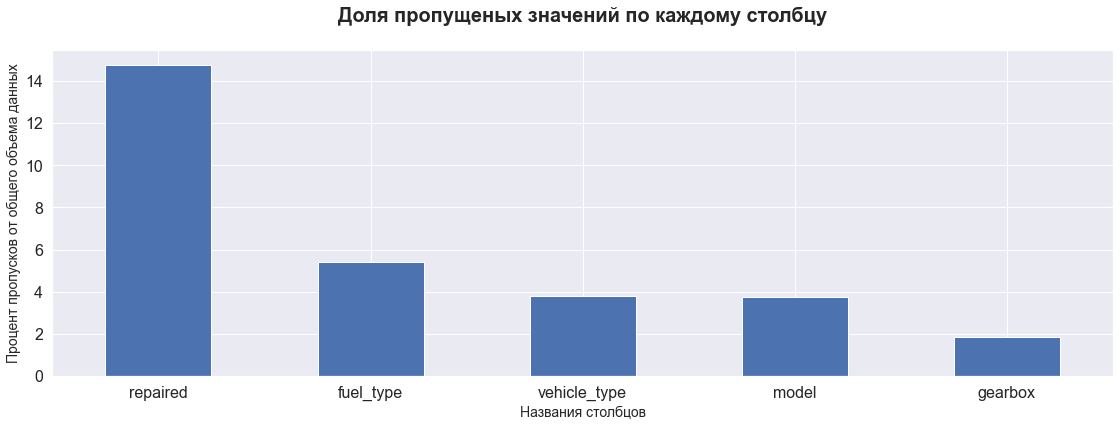

In [39]:
pass_value_barh(df)

#### repaired

Логично предположить, что пользователи не указавшие была ли машина в ремонте скорее всего иели ввиду, что она не была. Но мне кажется, что это достаточно важный показатель и он может сильно влиять на результат работы модели (на цену автомобиля). Поэтому предлагаю все пропуски в этом параметре заменить на 'unknown'

In [40]:
df['repaired'].fillna('unknown', inplace=True)
df['repaired'].isna().sum()

0

#### fuel_type

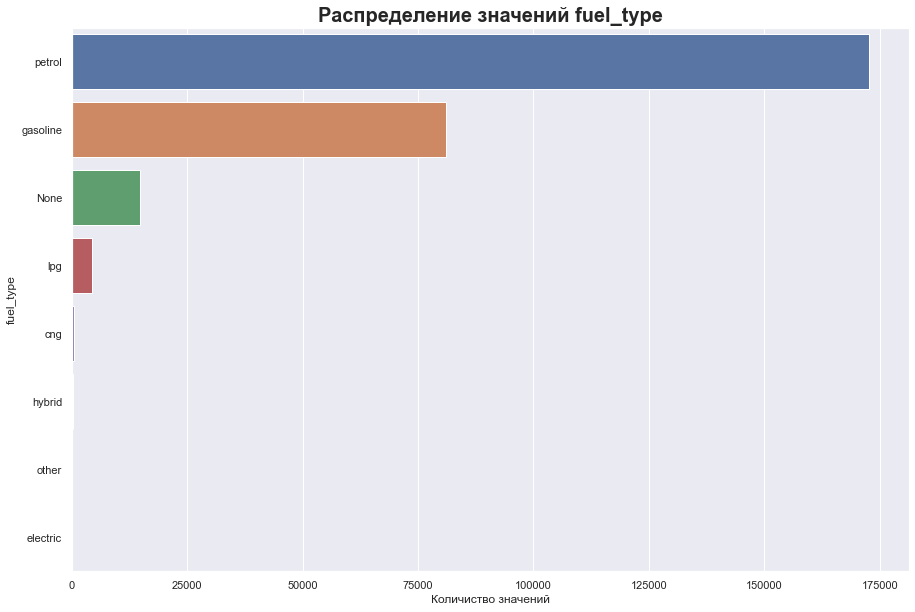

In [41]:
column_value_counts(df,
                    'fuel_type',
                    title='Распределение значений fuel_type'
                   )

Пропуски на третьем месте по частоте значений в столбце. Но в этом столбце можно попробовать избавиться от них взяв значения из автомобилей таких же моделей и бреднов. Конечно пропуски могут отсаться, есди это будет уникальная модель автомобиля - их придется удалить, но их количество точно уменьшится 

In [42]:
gropby_list = ['model', 'brand']
for i in gropby_list:
    fillna_pro(df, 'fuel_type', i)
df['fuel_type'].isna().sum()

0

Отлично, удалось заполнить все пропуски не теряя данных.

#### vehicle_type
Рассмотрим распределение значений по столбцу vehicle_type

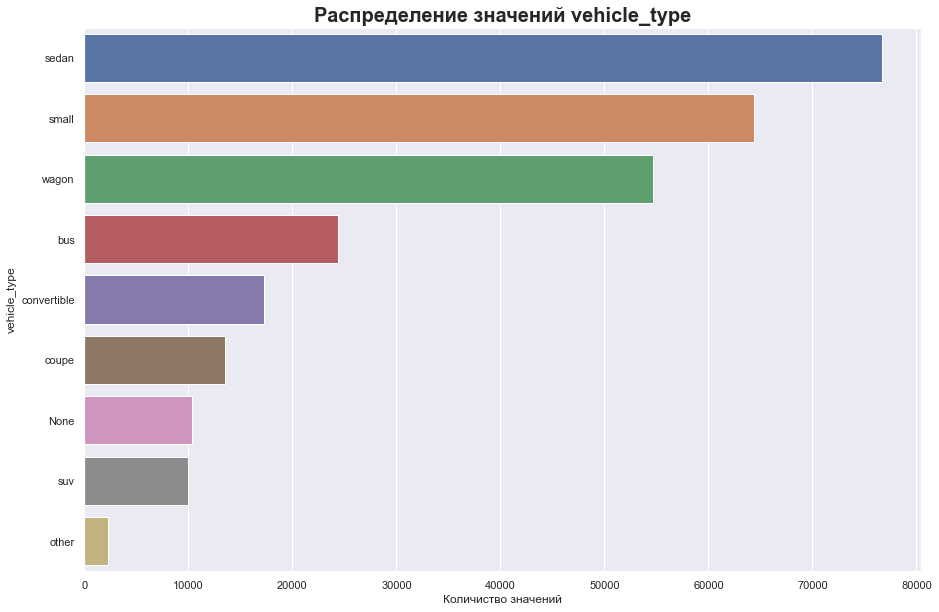

In [43]:
column_value_counts(df,
                    'vehicle_type',
                    title='Распределение значений vehicle_type',
                   )

Сдесь пропуски не входят в топ три. Предлагаю попробовать избавится от них так же как в столбце fuel_type.

In [44]:
for i in gropby_list:
    fillna_pro(df, 'vehicle_type', i)
df['vehicle_type'].isna().sum()

0

Отлично, тут тоже удалось избавиться от всех пропусков не удаляя данных.

#### model
Рассмотрим распределение значений по столбцу model

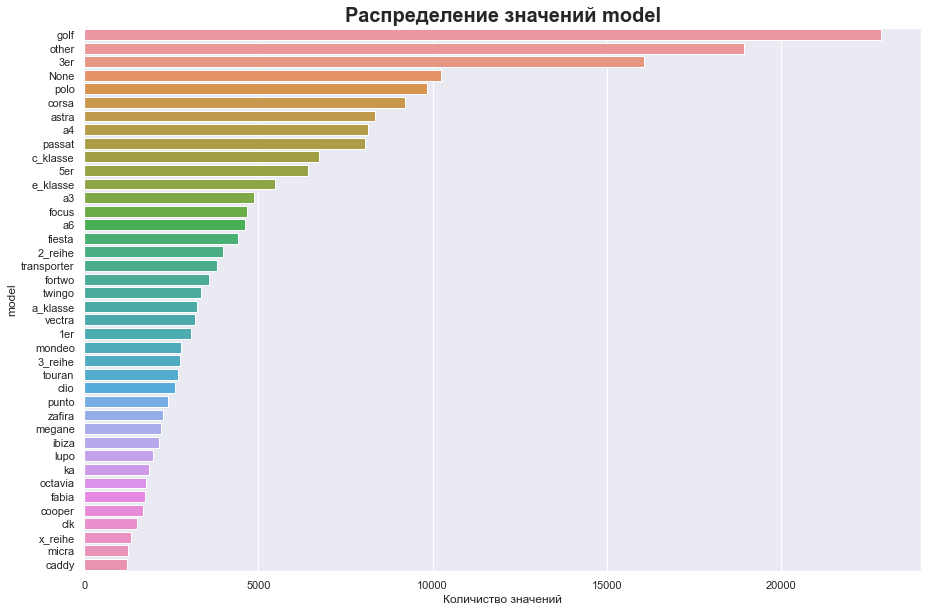

In [45]:
column_value_counts(df,
                    'model',
                    title='Распределение значений model',
                    n_values=40
                   )

Тут Nan значения занимают четвертое место. Но исправить их не получится, придется просто заменить их на unknown.

In [46]:
df['model'].fillna('unknown', inplace=True)
df['model'].isna().sum()

0

#### gearbox
Рассмотрим распределение значений в столбце gearbox.

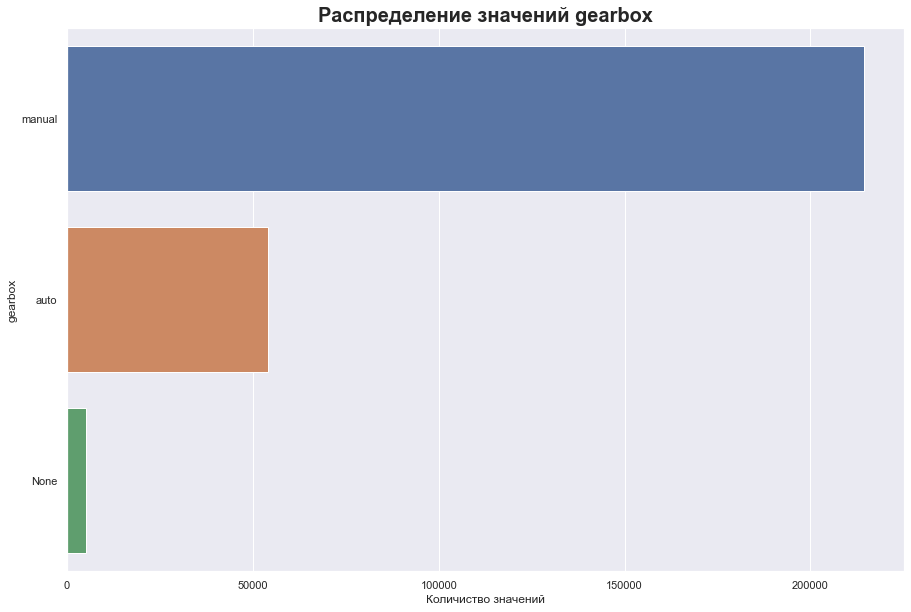

In [47]:
column_value_counts(df,
                    'gearbox',
                    title='Распределение значений gearbox',
                   )

Конечено будет на совсем верно заменять значение коробки передач, по машинам той же марки и модели, потому что даже внутри модели коробки могут быть разные, но это дас примерный результат. Поэтому считаю нужным это сделать.

In [48]:
for i in gropby_list:
    fillna_pro(df, 'gearbox', i)
df['gearbox'].isna().sum()

0

Отлично мы избавились от всех пропусков. Избавимся от более ненужных переменных.

Преобразуем типы данных, для того, чтобы они занимали меньше памяти.

In [49]:
int_cols = list(df.select_dtypes('integer').columns)
cat_cols = list(df.select_dtypes('object').columns)

df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
df[cat_cols] = df[cat_cols].astype('category')

Предобработка окончена, осталось только проверить не появились ли полные дубликаты из-за замен пропусков.

In [50]:
print(f'Число полных дубликатов : {df.duplicated().sum()}')

Число полных дубликатов : 848


Появилось несколько новых. Возможно это владельцы выкладывали одну анкету несколько раз, но заполняли ее по разному. Нужно их удалить.

In [51]:
df.drop_duplicates(inplace=True)
print(f'Число полных дубликатов : {df.duplicated().sum()}')

Число полных дубликатов : 0


Проверим какой процент данных мы потеряли и удалим все ненужные переменные.

In [52]:
print(f'Процент потерянных даннх: {(1 - df.shape[0] / df_shape_before_treatments):.1%}')

Процент потерянных даннх: 23.1%


In [53]:
del df_shape_before_treatments, gropby_list

### Вывод по предобработке данных

In [54]:
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272655 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   price              272655 non-null  int16   
 1   vehicle_type       272655 non-null  category
 2   registration_year  272655 non-null  int16   
 3   gearbox            272655 non-null  category
 4   power              272655 non-null  int16   
 5   model              272655 non-null  category
 6   kilometer          272655 non-null  int32   
 7   fuel_type          272655 non-null  category
 8   brand              272655 non-null  category
 9   repaired           272655 non-null  category
 10  postal_code        272655 non-null  int32   
dtypes: category(6), int16(3), int32(2)
memory usage: 7.6 MB


None

,price,registration_year,power,kilometer,postal_code
count,272655.000000,272655.000000,272655.000000,272655.000000,272655.000000
mean,4840.711819,2002.900391,120.771209,128533.769782,51474.882346
std,4600.651095,6.245035,53.975171,36554.798869,25775.522075
min,101.000000,1970.000000,15.000000,5000.000000,1067.000000
25%,1350.000000,1999.000000,77.000000,125000.000000,31134.000000
50%,3199.000000,2003.000000,111.000000,150000.000000,50667.000000
75%,6990.000000,2007.000000,150.000000,150000.000000,72336.000000
max,20000.000000,2016.000000,800.000000,150000.000000,99998.000000


В ходе предобработки данных мы:
- Были изучены и удалены все аномальные значения
- Были изучены все распределения
- Были удалены все пропуски
- Процент потерянных данных равен 23.1% - большой, но удаленные данные это выбросы и дубликаты, поэтому жалеть их не стоит

## Исследовательский анализ
Рассмотрим все будующие параметры в разрезе целевого признака.

### int features

 Так как размер датафрейма большой, на scatterplot-графике сложно будет что-то разглядеть, поэтому возьмем выборку из 30тыс значений.

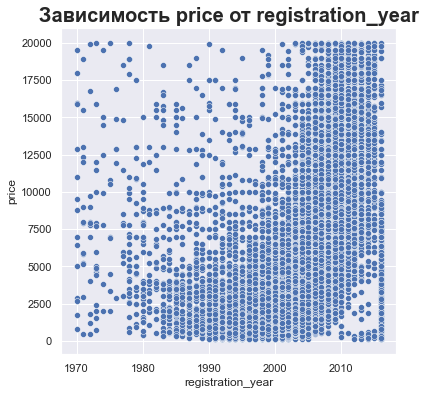

,price,registration_year
price,1.000000,0.514758
registration_year,0.514758,1.000000


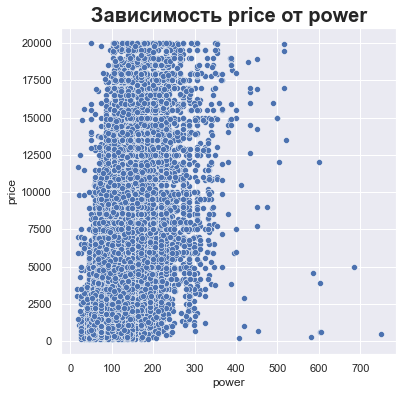

,price,power
price,1.000000,0.498645
power,0.498645,1.000000


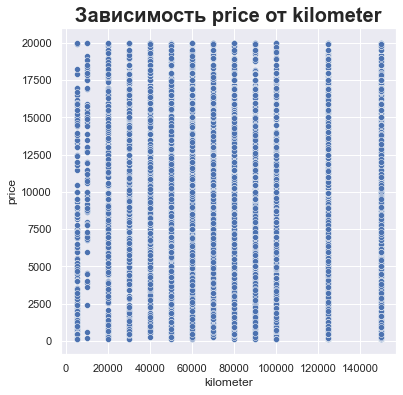

,price,kilometer
price,1.00000,-0.40215
kilometer,-0.40215,1.00000


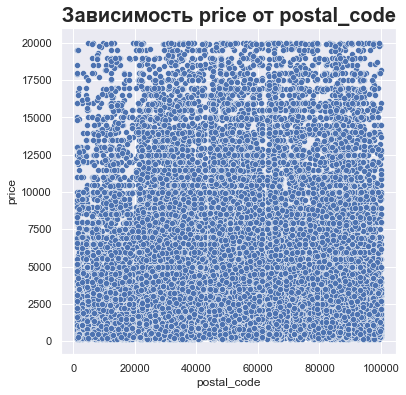

,price,postal_code
price,1.000000,0.070131
postal_code,0.070131,1.000000


In [55]:
for col in int_cols:
    if col == 'price':
        continue
    scatterplot_creator(df.sample(30000),  col, 'price', title=f'Зависимость price от {col}')

**По графикам видно**
- Цена зависит от года выпуска автомобиля, чем больше год, тем в большинстве случаев больше и цена
- Цена не так явно зависит от мощьности автомобиля, но некоторая зависимость прослеживается - чем больше мощьность, тем больше цена
- Есть совсем небольшая зависимость от пробега автомобиля
- Цена никак не зависит от индекса владельца, поэтому этот параметр можно удалить - он не поможет в предсказании цены.

In [56]:
df.drop('postal_code', axis=1, inplace=True)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


### catigory features

Рассмотрим распределение значений по категориальным признакам. Поскольку у нас есть категории в которых более 200-а видов значений рассмотрим 30 самыз дорогих - это уже позволит нам сделать вывод есть ли кака-либо зависимость цены от этх значений.

In [57]:
for col in cat_cols:
    print(col + ' :')
    display(pd
            .pivot_table(df, index=col, values='price', aggfunc=('mean', 'median'))
            .sort_values(by='mean', ascending=False).head(30))


vehicle_type :


,mean,median
vehicle_type,,
suv,9238.743643,8599.0
convertible,7017.744237,5699.0
coupe,6336.103410,4300.0
bus,5659.894825,4450.0
wagon,5105.582981,3499.0
sedan,4806.615140,3000.0
other,3943.994365,2600.0
small,2855.778086,1690.0


gearbox :


,mean,median
gearbox,,
auto,7143.360817,5850.0
manual,4262.513752,2750.0


model :


,mean,median
model,,
gl,18322.454545,18999.0
q5,16687.909091,17945.0
glk,16489.339286,17949.5
a5,16242.253304,16925.0
q7,16033.198675,16500.0
q3,15512.307692,18499.0
range_rover_sport,15281.040816,15500.0
v60,14912.486486,15990.0
kuga,14811.673387,15225.0


fuel_type :


,mean,median
fuel_type,,
hybrid,10202.606218,10900.0
electric,8948.630435,9150.0
gasoline,6830.796194,5500.0
cng,4607.271910,3890.0
lpg,4239.499884,3000.0
petrol,3951.746241,2300.0
other,2982.266667,1600.0


brand :


,mean,median
brand,,
porsche,12209.850435,12500.0
mini,9221.831741,8500.0
land_rover,8950.729604,8199.0
sonstige_autos,7570.861247,6499.0
jeep,7561.674766,6500.0
jaguar,7084.552311,5500.0
audi,6700.954002,5300.0
bmw,6603.050993,5400.0
mercedes_benz,6256.315326,4699.0


repaired :


,mean,median
repaired,,
no,5514.860514,3900.0
unknown,3161.683384,1800.0
yes,2186.665983,1100.0


**По данным видно:**
- Цена зависит от типа кузова машины, дороже всех стоит - suv, дешевле - small
- Цена зависит от типа коробки, машины с автоматической коробкой стоят примерно в два раза дороже чем машины с механической коробкой передачь
- Цена явно зависит от модели автомобиля
- Так же цена сильно зависит от вида топливо, которе используется в автомобиле. Самые дорогие машины используют гибридную заправку.
- Цена сильно зависит от марки автомобиля, самые дорогие машины имеют марку porshe
- Цена зависит от того, была ли машина в ремонте или нет. Машины которые не были в ремонте стоят дороже почти в три раза. Категория unknown стоит чуть дороже чем машины, которые ремонтировались, но не существенно.

### Вывод по исследовательскому анализу данных

- Были рассмотрены все столбцы (параметры будующей модели) в разрезе целового признака
- В столбцах с целочисленными переменными был удален столбец postal_code, так как он не имеет зависимости со стоимостью автомобиля
- В столбцах с категориальными значениями, ничего удалено небыло, так как цена зависит от всех значений

## Корреляционный анализ

In [58]:
interval_cols = ['price', 'power']

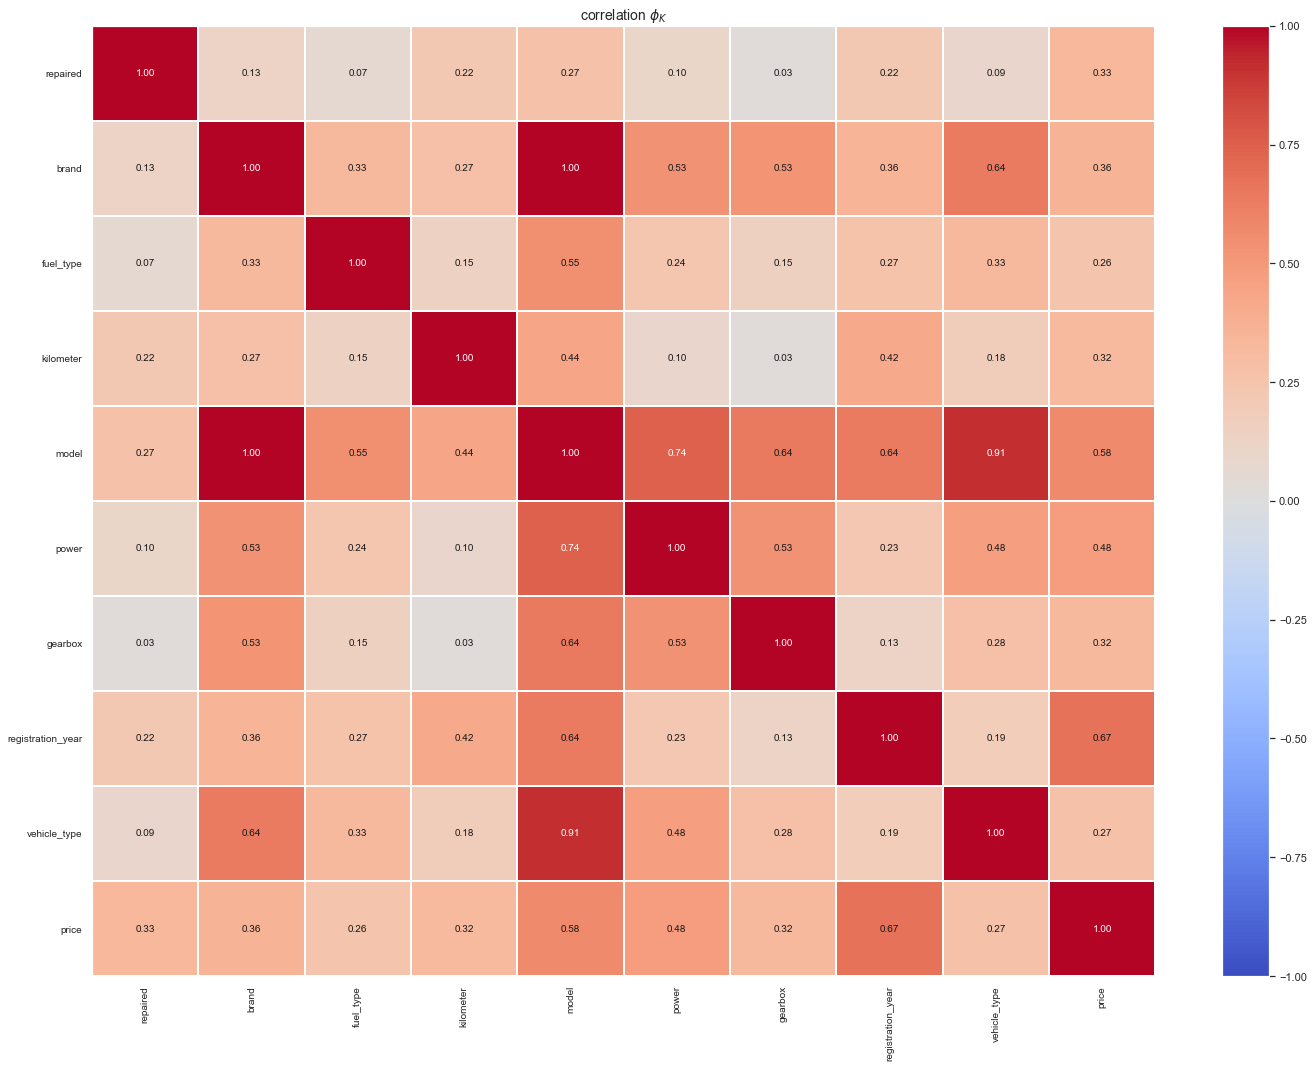

In [59]:
phik_overview = df.phik_matrix(interval_cols=int_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r'correlation $\phi_K$',
    color_map='coolwarm',
    figsize=(20, 15)
) 

В данных присутсвует мультиколлениарность параметр model коррелирует с параметрами brand и vehicle_type. Этот параметр стоит удалить для работы с линейными моделями и оставить его для работы моделей бустинга, потому что мультиколленеарность не мешает строиться дереву. 

In [60]:
df_linear = df.drop('model', axis=1)
df_linear.head()

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,150000,petrol,bmw,yes


## Подготовка данных

Подготовим дарные для ислопльзования линейной модели

In [61]:
RANDOM_STATE = 42

X_linear = df_linear.drop('price', axis=1)
y_linear = df_linear['price']

num_cols = list(X_linear.select_dtypes('integer').columns)
cat_cols = list(X_linear.select_dtypes('category').columns)
all_cols = num_cols + cat_cols

X_train, X_test, y_train, y_test  = train_test_split(X_linear,
                                                       y_linear,
                                                       test_size=.25,
                                                       random_state=RANDOM_STATE)

In [62]:
y_test.head()

325413     3790
113292     2999
111533     5749
344731    14400
25192      1599
Name: price, dtype: int16

In [63]:
ohe_pipe = Pipeline(
    [
        (
            'simple_imputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

preprocessing_pipe = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_cols),
        ('num', StandardScaler(), num_cols)
    ], 
    remainder='passthrough'
)

## Обучение модели

По причине ограниченного времени будем обучать только модели линейной регрессии Ridge, Lasso, LinearRegression и LigtGBMRegressor.

### Линейные модели

In [64]:
base_linear_model_pipe = Pipeline(
    [
        ('preprocessor', preprocessing_pipe),
        ('models', LinearRegression(n_jobs=-1))
    ]
)

param_grid = [
    {
        'models' : [LinearRegression(n_jobs=-1)],
    },
    {
        'models' : [Ridge(random_state=RANDOM_STATE)],
    },    
    {
        'models' : [Lasso(random_state=RANDOM_STATE)],
    }
]

In [65]:
%%time
rs = GridSearchCV(
    base_linear_model_pipe,
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    error_score='raise'
)
rs.fit(X_train, y_train)

print(f'Метрика RMSE лучшей модели на кросс-валидации равна {round(-rs.best_score_, 2)}')
print('Лучшая модель и ее гиперпараметры: \n', rs.best_estimator_)

Метрика RMSE лучшей модели на кросс-валидации равна 2715.83
Лучшая модель и ее гиперпараметры: 
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simple_imputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'fuel_type', 'brand',
                       

In [67]:
pd.set_option('display.max_colwidth', None)
linear_models_info_df = (pd.DataFrame(rs.cv_results_)
  [['params', 'mean_test_score', 'rank_test_score', 'mean_fit_time', 'mean_score_time']]
  .sort_values(by='mean_test_score', ascending=False))
linear_models_info_df['mean_test_score'] = -linear_models_info_df['mean_test_score']
linear_models_info_df

,params,mean_test_score,rank_test_score,mean_fit_time,mean_score_time
1,{'models': Ridge(random_state=42)},2715.830220,1,1.459694,0.249047
0,{'models': LinearRegression(n_jobs=-1)},2715.837171,2,6.161671,0.266440
2,{'models': Lasso(random_state=42)},2717.680585,3,13.414016,0.097802


Лучшей моделью по метрике является модель Ridge, метрика моделт LinearRegression практически не отличается от лучшей модели. Модель Lasso прогирывеает лучшей по метрике RMSE чуть сильнее, но сильным отличам не назовешь. Главный плюс модели Ridge это ее время обучения. Оно в три раза меньше чем у LinearRegression и примерно в 7 раз лучше чем у Lasso. Время предсказания почти у всех моделей не сильно отличатся - но самое быстрое у Lasso, но разни Вывод лучшей моделью на этом этапе является модель Ridge она побеждает благодоря быстрому времени обучения.

Рассмотрим модель градиентного бустинга.

### LightGBM

Для этой модели придется провести небольшую подготовку данных еще раз.

In [68]:
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test  = train_test_split(X,
                                                     y,
                                                     test_size=.25,
                                                     random_state=RANDOM_STATE)

In [69]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
X_test.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
325413,small,0.494790,manual,-1.033194,other,-1.329358,petrol,fiat,no
113292,small,0.014283,manual,-1.051698,polo,0.586806,petrol,volkswagen,no
111533,wagon,0.975297,manual,-0.089462,focus,-0.097538,petrol,ford,no
344731,coupe,0.975297,manual,0.909783,3er,-0.097538,petrol,bmw,no
25192,small,-0.626392,manual,-0.200489,a3,0.586806,gasoline,audi,yes


In [70]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
X_cv = pd.concat([train_data.data])
y_cv = pd.concat([train_data.label])
y_cv.head()

192217    9350
93147      850
338120    3900
219691    7400
248370    2800
Name: price, dtype: int16

In [74]:
%%time

lgb_results = []

def objective(trial, X_cv, y_cv):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": 1000,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE) 
    
    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_cv, y_cv)):  
        X_train, X_test = X_cv.iloc[train_idx], X_cv.iloc[test_idx] 
        y_train, y_test = y_cv.iloc[train_idx], y_cv.iloc[test_idx]
        
        model = LGBMRegressor(**params, n_jobs=-1, random_state=RANDOM_STATE)
        
        start_fit = time()
        
        model.fit(
            X_train,
            y_train,
            categorical_feature=cat_cols,
            verbose=False
        )
        
        end_fit = time()
        fit_time = round((end_fit - start_fit), 2)
        
        start_pred = time()
        
        preds = model.predict(X_test)  
        
        end_pred = time()
        predict_time = round((end_pred - start_pred), 4)
        
        cv_scores[idx] = mse(y_test, preds, squared=False)
        rmse = mse(y_test, preds, squared=False)
        
        lgb_results.append({'model': model, 'training_time': fit_time, 'prediction_time': predict_time, 'rmse': rmse})

        
    return np.mean(cv_scores)
    
    
study = optuna.create_study(direction="minimize")
func = lambda trial: objective(trial, X_cv, y_cv)
study.optimize(func, n_trials=20) 

lgb_results = pd.DataFrame(lgb_results)

[I 2024-02-15 23:27:21,331] A new study created in memory with name: no-name-688fc7c4-c5df-4ba9-9a41-9992fdaf1a51
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-15 23:28:02,307] Trial 0 finished with value: 1545.102856052428 and parameters: {'learning_rate': 0.0414809815665648, 'num_leaves': 81, 'subsample': 0.29610300899687253, 'colsample_bytree': 0.795998716389392, 'min_data_in_leaf': 83}. Best is trial 0 with value: 1545.102856052428.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=73, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=73
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-15 23:28:22,824] Trial 1 finished with value: 2085.6205339473013 and parameters: {'learning_rate': 0.0017631827519493724, 'num_leaves': 29, 'subsample': 0.5066435860862217, 'colsample_bytree': 0.9476612233896109, 'min_data_in_leaf': 73}. Best is trial 0 with value: 1545.102856052428.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-15 23:30:03,871] Trial 2 finished with value: 1527.0618105736928 and parameters: {'learning_rate': 0.033613950458710476, 'num_leaves': 413, 'subsample': 0.540759119360613, 'colsample_bytree': 0.5091084506085513, 'min_data_in_leaf': 87}. Best is trial 2 with value: 1527.0618105736928.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-15 23:30:19,727] Trial 3 finished with value: 2510.7931471324405 and parameters: {'learning_rate': 0.0050460053617478445, 'num_leaves': 405, 'subsample': 0.09257601060074588, 'colsample_bytree': 0.1129361701502611, 'min_data_in_leaf': 22}. Best is trial 2 with value: 1527.0618105736928.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-15 23:30:29,573] Trial 4 finished with value: 2618.1122322793103 and parameters: {'learning_rate': 0.005062695676286112, 'num_leaves': 8, 'subsample': 0.11954262451167222, 'colsample_bytree': 0.07525950294603063, 'min_data_in_leaf': 30}. Best is trial 2 with value: 1527.0618105736928.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-15 23:31:41,418] Trial 5 finished with value: 1514.758832931871 and parameters: {'learning_rate': 0.020564533186421586, 'num_leaves': 288, 'subsample': 0.9993490514919802, 'colsample_bytree': 0.7947144414428154, 'min_data_in_leaf': 10}. Best is trial 5 with value: 1514.758832931871.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=76, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=76
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-15 23:33:22,189] Trial 6 finished with value: 1649.8874909693652 and parameters: {'learning_rate': 0.006913451998472233, 'num_leaves': 479, 'subsample': 0.7431145451005418, 'colsample_bytree': 0.3791875705247893, 'min_data_in_leaf': 76}. Best is trial 5 with value: 1514.758832931871.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-15 23:35:19,172] Trial 7 finished with value: 1596.1512294287218 and parameters: {'learning_rate': 0.00495942093677253, 'num_leaves': 564, 'subsample': 0.7002628422585446, 'colsample_bytree': 0.428052755525854, 'min_data_in_leaf': 39}. Best is trial 5 with value: 1514.758832931871.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-15 23:36:18,824] Trial 8 finished with value: 1530.0880976030767 and parameters: {'learning_rate': 0.05081560200763902, 'num_leaves': 150, 'subsample': 0.38403230811385836, 'colsample_bytree': 0.6997438943303116, 'min_data_in_leaf': 72}. Best is trial 5 with value: 1514.758832931871.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-15 23:37:14,065] Trial 9 finished with value: 1542.6323720609998 and parameters: {'learning_rate': 0.05909671744586806, 'num_leaves': 223, 'subsample': 0.711287482605371, 'colsample_bytree': 0.47161177983280916, 'min_data_in_leaf': 6}. Best is trial 5 with value: 1514.758832931871.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-15 23:40:18,012] Trial 10 finished with value: 1521.6839560175029 and parameters: {'learning_rate': 0.014164731312658736, 'num_leaves': 896, 'subsample': 0.9684971464126828, 'colsample_bytree': 0.930469072102189, 'min_data_in_leaf': 1}. Best is trial 5 with value: 1514.758832931871.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-15 23:43:54,222] Trial 11 finished with value: 1539.5378607794592 and parameters: {'learning_rate': 0.017907268066497516, 'num_leaves': 995, 'subsample': 0.9738090040280735, 'colsample_bytree': 0.982977133435304, 'min_data_in_leaf': 1}. Best is trial 5 with value: 1514.758832931871.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-15 23:47:05,712] Trial 12 finished with value: 1515.4860849796535 and parameters: {'learning_rate': 0.016895800367077874, 'num_leaves': 858, 'subsample': 0.9548918251612887, 'colsample_bytree': 0.7902209165531872, 'min_data_in_leaf': 15}. Best is trial 5 with value: 1514.758832931871.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-15 23:49:47,066] Trial 13 finished with value: 1514.6804498564402 and parameters: {'learning_rate': 0.021146533276679966, 'num_leaves': 704, 'subsample': 0.9824432475797255, 'colsample_bytree': 0.7046529858547504, 'min_data_in_leaf': 53}. Best is trial 13 with value: 1514.6804498564402.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-15 23:52:27,114] Trial 14 finished with value: 1564.2775786846462 and parameters: {'learning_rate': 0.09573507142987306, 'num_leaves': 696, 'subsample': 0.8489399294285679, 'colsample_bytree': 0.6522392455035295, 'min_data_in_leaf': 44}. Best is trial 13 with value: 1514.6804498564402.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-15 23:53:49,377] Trial 15 finished with value: 1517.4559111267224 and parameters: {'learning_rate': 0.02408247976226197, 'num_leaves': 285, 'subsample': 0.8335365888186475, 'colsample_bytree': 0.6252266567157904, 'min_data_in_leaf': 61}. Best is trial 13 with value: 1514.6804498564402.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-15 23:56:27,664] Trial 16 finished with value: 1522.0214724526454 and parameters: {'learning_rate': 0.010388309357550593, 'num_leaves': 644, 'subsample': 0.9828181272999069, 'colsample_bytree': 0.8389311076101192, 'min_data_in_leaf': 53}. Best is trial 13 with value: 1514.6804498564402.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=57
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-15 23:59:13,740] Trial 17 finished with value: 1518.5664679534268 and parameters: {'learning_rate': 0.026150793497124708, 'num_leaves': 745, 'subsample': 0.847948940038594, 'colsample_bytree': 0.580768144947324, 'min_data_in_leaf': 57}. Best is trial 13 with value: 1514.6804498564402.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-16 00:00:42,410] Trial 18 finished with value: 1538.7956564109 and parameters: {'learning_rate': 0.009769665834523626, 'num_leaves': 318, 'subsample': 0.8934930697392054, 'colsample_bytree': 0.692539312834092, 'min_data_in_leaf': 100}. Best is trial 13 with value: 1514.6804498564402.
The least populated class in y has only 1 members, which is less than n_splits=5.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.


[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-02-16 00:02:54,574] Trial 19 finished with value: 1523.717092553687 and parameters: {'learning_rate': 0.030478421800023976, 'num_leaves': 528, 'subsample': 0.8062871347591591, 'colsample_bytree': 0.856728763437836, 'min_data_in_leaf': 36}. Best is trial 13 with value: 1514.6804498564402.


Wall time: 35min 33s


Создадим модель с такими же характеристиками, чтобы узнать как долго она обучается и дает предсказания.

In [75]:
lgb_results.sort_values(by='rmse', ascending=True).head()


,model,training_time,prediction_time,rmse
67,"LGBMRegressor(bagging_freq=1, colsample_bytree=0.7046529858547504,\n learning_rate=0.021146533276679966, metric='rmse',\n min_data_in_leaf=53, n_estimators=1000, num_leaves=704,\n objective='regression', random_state=42,\n subsample=0.9824432475797255, verbosity=-1)",27.87,0.0,1484.673201
27,"LGBMRegressor(bagging_freq=1, colsample_bytree=0.7947144414428154,\n learning_rate=0.020564533186421586, metric='rmse',\n min_data_in_leaf=10, n_estimators=1000, num_leaves=288,\n objective='regression', random_state=42,\n subsample=0.9993490514919802, verbosity=-1)",11.21,0.0,1485.416181
62,"LGBMRegressor(bagging_freq=1, colsample_bytree=0.7902209165531872,\n learning_rate=0.016895800367077874, metric='rmse',\n min_data_in_leaf=15, n_estimators=1000, num_leaves=858,\n objective='regression', random_state=42,\n subsample=0.9548918251612887, verbosity=-1)",34.07,0.0,1488.067031
87,"LGBMRegressor(bagging_freq=1, colsample_bytree=0.580768144947324,\n learning_rate=0.026150793497124708, metric='rmse',\n min_data_in_leaf=57, n_estimators=1000, num_leaves=745,\n objective='regression', random_state=42,\n subsample=0.847948940038594, verbosity=-1)",27.60,0.0,1489.015261
77,"LGBMRegressor(bagging_freq=1, colsample_bytree=0.6252266567157904,\n learning_rate=0.02408247976226197, metric='rmse',\n min_data_in_leaf=61, n_estimators=1000, num_leaves=285,\n objective='regression', random_state=42,\n subsample=0.8335365888186475, verbosity=-1)",12.66,0.0,1489.046600


Все модели пртестированны можно переходить к анализу моделей

## Анализ моделей

Еще раз введем таблицы с моделями изученными в данном проекте.

In [76]:
linear_models_info_df

,params,mean_test_score,rank_test_score,mean_fit_time,mean_score_time
1,{'models': Ridge(random_state=42)},2715.830220,1,1.459694,0.249047
0,{'models': LinearRegression(n_jobs=-1)},2715.837171,2,6.161671,0.266440
2,{'models': Lasso(random_state=42)},2717.680585,3,13.414016,0.097802


In [77]:
lgb_results.sort_values(by='rmse', ascending=True).head()

,model,training_time,prediction_time,rmse
67,"LGBMRegressor(bagging_freq=1, colsample_bytree=0.7046529858547504,\n learning_rate=0.021146533276679966, metric='rmse',\n min_data_in_leaf=53, n_estimators=1000, num_leaves=704,\n objective='regression', random_state=42,\n subsample=0.9824432475797255, verbosity=-1)",27.87,0.0,1484.673201
27,"LGBMRegressor(bagging_freq=1, colsample_bytree=0.7947144414428154,\n learning_rate=0.020564533186421586, metric='rmse',\n min_data_in_leaf=10, n_estimators=1000, num_leaves=288,\n objective='regression', random_state=42,\n subsample=0.9993490514919802, verbosity=-1)",11.21,0.0,1485.416181
62,"LGBMRegressor(bagging_freq=1, colsample_bytree=0.7902209165531872,\n learning_rate=0.016895800367077874, metric='rmse',\n min_data_in_leaf=15, n_estimators=1000, num_leaves=858,\n objective='regression', random_state=42,\n subsample=0.9548918251612887, verbosity=-1)",34.07,0.0,1488.067031
87,"LGBMRegressor(bagging_freq=1, colsample_bytree=0.580768144947324,\n learning_rate=0.026150793497124708, metric='rmse',\n min_data_in_leaf=57, n_estimators=1000, num_leaves=745,\n objective='regression', random_state=42,\n subsample=0.847948940038594, verbosity=-1)",27.60,0.0,1489.015261
77,"LGBMRegressor(bagging_freq=1, colsample_bytree=0.6252266567157904,\n learning_rate=0.02408247976226197, metric='rmse',\n min_data_in_leaf=61, n_estimators=1000, num_leaves=285,\n objective='regression', random_state=42,\n subsample=0.8335365888186475, verbosity=-1)",12.66,0.0,1489.046600


Самой быстрой линейной моделью является моедль Ridge - она же является и самой точно, рассматривать остальные линейные модели не имеет смысла, так как обучаются они дольше, предсказания их хуже, а время предсказания у них пости не отличается - отличается только на милисекунды. Главная проблема всех трех изученных линейных моделей в том, что их предсказания очень не точные и не удовлетворяют требованиям - требуется чтобы метрика RMSE была бы меньше или равна 2500, но к сожалению метрика самой точной линейной модели не удовлетворяет этому требованию, поэтому как бы быстро она не обучалась она не подходит заказчику.

Что касаемо модели LGBMRegressor она обучается значительно дольше чем линейные модели, но и предсказания ее практически в два раза точнее чем у линейной моедли. Время предсказания тоже больше чем у линейных моделей, но опять же качество намного выше. Я бы посоветовал заказчику остоновиться заказчику остановиться на выборе не самой точной модели LGBMRegressor, а на модели точность которой заняла второе место на этапе кросс-валидации, но ее время обучения в два раза меньше чем у самой точной модели, а точность модели отличается меньше чем на один евро. Протестируем эту модель на тесте.

### Предсказание на тесте самой точной модели

In [79]:
best_model = lgb_results['model'][27]

In [89]:
start = time()
best_model.fit(train_data.data, train_data.label)
end = time()
fit_best_model_time = round(end - start, 2)
print(f'Время обучения лучшей выбранной модели - {fit_best_model_time}')

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Время обучения лучшей выбранной модели - 14.91


In [90]:
start = time()
prediction_best_model = best_model.predict(test_data.data)
end = time()
predict_best_model_time = round(end - start, 2)
print(f'Время предсказания лучшей выбранной модели - {predict_best_model_time}')

Время предсказания лучшей выбранной модели - 5.06


In [99]:
test_rmse = round(mse(test_data.label, prediction_best_model, squared=False), 2)
print(f'Метрика RMSE на тестовых данных - {test_rmse}')

Метрика RMSE на тестовых данных - 1485.11


Модель дала достаточно точный результат на абсолютно новых для нее даннх. Я считаю, что это лучший вариант для заказчика. Время обучения на достаточно большом объеме данных не превысило 20 секунд. Я считаю, что это допустимое время обучения для модели имеющей такую точность предсказаний.

### Интерпритация модели LGBMRegressor

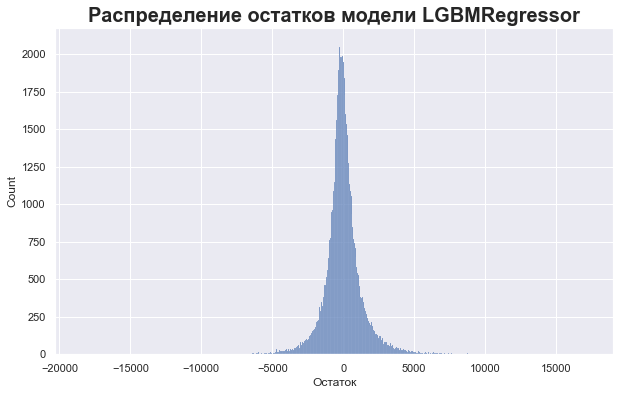

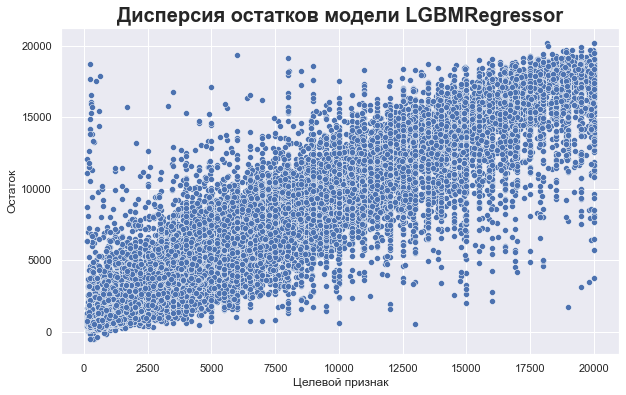

In [96]:
residuals(test_data.label.reset_index(drop=True), prediction_best_model, 'LGBMRegressor')

Распределение остатков модели LGBMRegressor походит на нормальное. По графикам видно, что модель лучше спревляется с предсказанием стоимости дешевых автомобилей. Так же по графикам видно, что модель градиентного бустинга очень редко предсказывает бОльшую стоимость, в основном она ее занижает и чем дороже машина в объявлении тем более вероятно, что модель занизит их стоимость.

,feature,gain
3,power,89592
1,registration_year,76715
5,kilometer,43885
4,model,22652
8,repaired,18726
7,brand,12391
2,gearbox,11035
0,vehicle_type,8863
6,fuel_type,3141


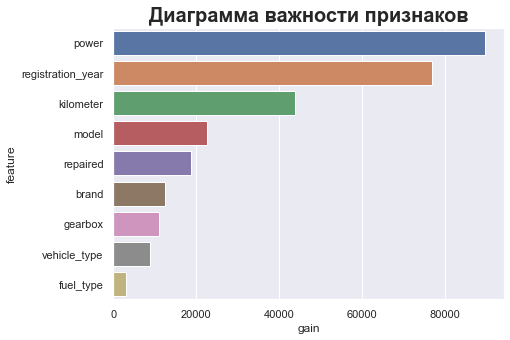

In [98]:
gain_importance = best_model.feature_importances_
feature_names = best_model.feature_name_
gain_importance_df = pd.DataFrame({'feature': feature_names, 'gain': gain_importance})
display(gain_importance_df.sort_values(by='gain', ascending=False))
plt.figure(figsize=(7, 5))
sns.barplot(data=gain_importance_df.sort_values(by='gain', ascending=False),
            x='gain',
            y='feature')
plt.title('Диаграмма важности признаков',
          fontsize=20,
          fontweight='bold')  
plt.show()

По данным видно:
- Самым важным признаком для модели оказалась мощьность - это значение сильнее всего влияет на результат работы модели
- Чуть слабее на результат модели влияет год выпуска автомобиля
- Пробег влияет на работу модели (на стоимость автомобиля) уже значительно слабее чем прошлые признаки
- Немного слабее на результат работы модели влияет ее модель
- Еще более слабое влияние на результат цены оказывает фактор - была ли в машина в ремонте или нет
- Бренд и тип коробки влият одинаково, но уже достаточно слабо
- Осатльны признаки слабо влияют на результат работы модели

## Общий вывод
1. **Предобработка данных**
    - Были изучены все распределения
    - Были удалены все пропуски
    - Процент потерянных данных равен 23.1% - большой, но удаленные данные это выбросы и дубликаты, поэтому жалеть их не стоит
2. **Исследовательский анализ данных**
    - Были рассмотрены все столбцы (параметры будующей модели) в разрезе целового признака
    - В столбцах с целочисленными переменными был удален столбец postal_code, так как он не имеет зависимости со стоимостью автомобиля
    - В столбцах с категориальными значениями, ничего удалено небыло, так как цена зависит от всех значений
3. **Корреляционный анализ**
    - Была убрана мультиколлениарность в данных
4. **Подотовка данных**
    - Данные были подготовлены для работы с моделями машинного обучения
5. **Обучение модлей**
    - Были обученны модели линейной регрессии такие как:
        - LinearRegression
        - Ridge
        - Lasso
    - При помощи кросс-валидации была подобрана модель с лучшими параметрами ей оказалась модель Ridge. Результат метрики RMSE на кросс-валидации - 2715.83
    - Была обученна модель градиентного бустинга LGBMRegressor
    - При помощи оптуны и кросс-валидации были подбранны лучшие параметры
    - Результат метрики RMSE самой точной модели на кросс-валидации равен - 1484.67
6. **Анализ моделей**
    - Были изучены самые точные (лучшие - выбранные на кросс-валидации) модели
    - Главным плюсом линейных моделей явлется скорость их обучени, главным минусом, что метрика RMSR даже самой точной модели бльше 2500
    - Главным плюсом модели LGBRegressor является точность предсказаний. Главным минусом - время обучения - оно больше чем у линейных моделей
    - Была выбрана лучшая модель ей оказалась LGBMRegressor ее результат на тесте равен - 1485.11
    - Была модель которая на этапе кросс-валидации уступала в точности самой точной модели (на кросс валидации она была менее точной меньше чем на один евро), так как время ее обучения в два раза меньше
    - Был проведен анализ распределения и дисперсии остатков моделей лучшей моделеи
    - Были проинтерпретированны влияния признаков на резльтат работы моделей